<a href="https://colab.research.google.com/github/jdiazram/lecturasIIC3633-2021/blob/main/practicos/pyreclab_svd_JDR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica de Sistemas Recomendadores: pyreclab - Funk's SVD

En este práctico implementaremos un recomendador basado en un algoritmo de factorización matricial propuesto por [Simon Funk](https://sifter.org/simon/journal/20061211.html).

Volveremos a utilizar la biblioteca de Python [pyreclab](https://github.com/gasevi/pyreclab), desarrollado por los Laboratorios IALab y SocVis de la Pontificia Universidad Católica de Chile.

**Adaptado por**: Vladimir Araujo

**Material original de**: Denis Parra, Gabriel Sepúlveda, Antonio Ossa, Manuel Cartagena


## Configuración inicial

**Paso 1:** Descargue directamente a Colab los archivos del dataset ejecutando las siguientes 3 celdas:

In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    256      0 --:--:--  0:00:01 --:--:--   256
100 1546k  100 1546k    0     0   865k      0  0:00:01  0:00:01 --:--:--  865k


In [2]:
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    455      0 --:--:-- --:--:-- --:--:--   455
100  385k  100  385k    0     0   357k      0  0:00:01  0:00:01 --:--:--  357k


In [3]:
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    751      0 --:--:-- --:--:-- --:--:--   750
100  230k  100  230k    0     0   315k      0 --:--:-- --:--:-- --:--:--  315k


**Paso 2**: Instalamos [`pyreclab`](https://github.com/gasevi/pyreclab) y [`seaborn`](https://seaborn.pydata.org/index.html) utilizando `pip`.

In [4]:
!pip install pyreclab --upgrade
#!pip install seaborn --upgrade

In [5]:
import pandas as pd
import pyreclab
import seaborn as sns
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="whitegrid")

## Antes de recomendar

**Paso 3**: Los archivos `u2.base` y `u2.test` tienen tuplas (usuario, item, rating, timestamp), que es la información de preferencias de usuarios sobre películas en una muestra del dataset [MovieLens](https://grouplens.org/datasets/movielens/). Revisemos cómo es uno de estos archivos y luego haremos gráficos que nos permitan sacar conclusiones a partir del mismo.

In [6]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,4,878542960
1,1,4,3,876893119
2,1,5,3,889751712
3,1,6,5,887431973
4,1,7,4,875071561


In [7]:
# Ahora queremos realizar una observación rápida de los datos
df_train.describe()

,userid,itemid,rating,timestamp
count,80000.000000,80000.000000,80000.000000,8.000000e+04
mean,494.508137,424.990487,3.526463,8.835467e+08
std,276.879511,330.564093,1.124429,5.379549e+06
min,1.000000,1.000000,1.000000,8.747247e+08
25%,269.000000,174.000000,3.000000,8.794471e+08
50%,500.000000,321.000000,4.000000,8.828278e+08
75%,744.000000,630.000000,4.000000,8.884652e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


Por otra parte, para obtener información adicional de cada película tal como **título**, **fecha de lanzamiento**, **género**, etc., cargaremos el archivo de items descargado (`u.item`) para poder mapear cada identificador de ítem al conjunto de datos que lo describe. Revisemos el contenido de este archivo

In [8]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [9]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [10]:
# Realizamos una inspección sobre estos datos (.info())
df_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1682 entries, 1 to 1682
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               1682 non-null   object 
 1   release_date        1681 non-null   object 
 2   video_release_date  0 non-null      float64
 3   IMDb_URL            1679 non-null   object 
 4   unknown             1682 non-null   int64  
 5   Action              1682 non-null   int64  
 6   Adventure           1682 non-null   int64  
 7   Animation           1682 non-null   int64  
 8   Children            1682 non-null   int64  
 9   Comedy              1682 non-null   int64  
 10  Crime               1682 non-null   int64  
 11  Documentary         1682 non-null   int64  
 12  Drama               1682 non-null   int64  
 13  Fantasy             1682 non-null   int64  
 14  Film-Noir           1682 non-null   int64  
 15  Horror              1682 non-null   int64  
 16  Musica

In [11]:
# Ejemplo de cómo visualizar titulos de peliculas en base a sus IDs
pelis = [5,4,1]
df_items.loc[pelis]['title']

movieid
5       Copycat (1995)
4    Get Shorty (1995)
1     Toy Story (1995)
Name: title, dtype: object

**Paso 4:** Generemos algunos gráficos en relación a las películas.

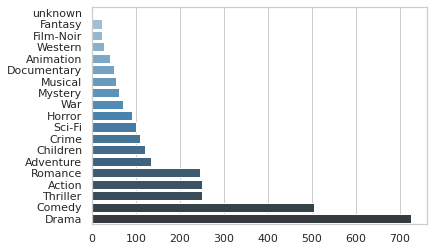

In [12]:
#Ignorar el warning
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

genre_count = df_items[genre_columns].sum().sort_values()

sns.barplot(x=genre_count.values, y=genre_count.index, label="Total", palette="Blues_d")

Antes de trabajar con SVD, responda las siguientes preguntas.

**Pregunta:** Explique cómo funciona SVD (como modelo, no piense en la implementación), y cómo funciona el método `train()` en  `pyreclab`





**Respuesta: SVD dice que se puede factorizar una matriz R en 3 matrices:

$$
    \mathbf{R} = \mathbf{M Diag U}^{T}
$$

- M y U son matrices ortogonales
- Diag es una matriz diagonal de valores singulares

Lo anterior se puede usar en recomendaciones debido a que R no esta definida, puesto a que la Matriz R es la matriz usuario-items con rating, pero sparse.

El método `train()` de `pyrelab` realiza un "entrenamiento" de los datos de entrada (para este ejemplo u2.base) un número máximo de iteraciones (maxiter), una tasa de aprendizaje (lr = Learning rate), un parámetro de regularización (lamb).

## SVD

**Paso 5**: Tome un usuario, cualquiera, del dataset y reporte parte de sus gustos explícitamente (es decir, nombre de las películas, género, etc., no id). Para este mismo usuario, revise explícitamente las recomendaciones al llegar a la parametrización que reporta las mejores métricas.

In [13]:
user_id = 2
user_df = df_train[df_train['userid'] == user_id]

df_items.loc[user_df['itemid'].values]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
13,Mighty Aphrodite (1995),30-Oct-1995,NaN,http://us.imdb.com/M/title-exact?Mighty%20Aphr...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
19,Antonia's Line (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Antonia%20(1995),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
100,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
127,"Godfather, The (1972)",01-Jan-1972,NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...",0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
237,Jerry Maguire (1996),13-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Jerry%20Magui...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
251,Shall We Dance? (1996),11-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Shall%20we%20...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
255,My Best Friend's Wedding (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?My+Best+Frien...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
257,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [14]:
# Definicion de objeto svd
svd = pyreclab.SVD(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

# Entrenamiento del modelo
svd.train(factors=100, maxiter=100, lr=0.01, lamb=0.1)

In [15]:
# Testing de predicciones
predlist, mae, rmse = svd.test(input_file='u2.test',
                               dlmchar=b'\t',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

print('MAE: {}\nRMSE: {}'.format(mae, rmse))

MAE: 0.7203726407267541
RMSE: 0.9138315517743317


In [16]:
# Testing de recomendaciones
top_n = 20

recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAP: 0.11002254213208439
NDCG@20: 0.061928119583513325


In [17]:
# Calcular las recomendaciones para el usuario escogido
ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))

Recommendation for user 2: [1449, 169, 1512, 1367, 1398, 64, 408, 12, 318, 480, 483, 1450, 189, 174, 1467, 511, 603, 187, 8, 1642]


In [18]:
# Ver explicitamente las recomendaciones para un usuario
df_items.loc[ranking]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1449,Pather Panchali (1955),22-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Pather%20Panc...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
169,"Wrong Trousers, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Wrong%20Trous...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1512,"World of Apu, The (Apur Sansar) (1959)",05-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Apur%20Sansar...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1367,Faust (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Faust%20%2819...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1398,Anna (1996),13-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Anna%20(1996),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
64,"Shawshank Redemption, The (1994)",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Shawshank%20R...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
408,"Close Shave, A (1995)",28-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Close%20Shave...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
12,"Usual Suspects, The (1995)",14-Aug-1995,NaN,http://us.imdb.com/M/title-exact?Usual%20Suspe...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
318,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


**Paso 6:** Pruebe distintos valores de los parámetros de entrenamiento del algoritmo SVD:
- Número de factores
- Número de iteraciones máxima
- Learning rate
- Lambda

Describa cómo estos afectan las métricas y las recomendaciones hechas para el usuario que escogió: *COMPLETAR*

`Resultados originales`

factors=100, maxiter=100, lr=0.01, lamb=0.1

MAE: 0.7207845727175296, RMSE: 0.9148834957986172

MAP: 0.11503800939976919, NDCG@20: 0.06401603881695755

Recommendation for user 2: [1449, 169, 1512, 1367, 1398, 64, 408, 12, 318, 480, 483, 1450, 189, 174, 1467, 511, 603, 187, 8, 1642]

In [19]:
# modificacion 1
svd.train(factors=50, maxiter=100, lr=0.01, lamb=0.1)
# Testing de predicciones
predlist, mae, rmse = svd.test(input_file='u2.test',
                               dlmchar=b'\t',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

print('MAE: {}\nRMSE: {}'.format(mae, rmse))
# Testing de recomendaciones
top_n = 20
recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))
# Calcular las recomendaciones para el usuario escogido
ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))

MAE: 0.721158578086971
RMSE: 0.9160360412691545
MAP: 0.09456682054684484
NDCG@20: 0.054584951912598635
Recommendation for user 2: [1512, 1449, 1500, 169, 1367, 12, 1398, 1467, 187, 119, 1064, 483, 134, 1189, 1558, 923, 408, 48, 174, 64]


Al realizar la modificacióón 1, bajar los factores latentes de 100 a 50, se observan que las mediciones se mantuvieron similares pero con variaciones muy leves, y en la recomendación de top 20 existen otras recomendaciones, por lo tanto tener diferentes cantidades de factores latentes afecta en las recomendaciones.

In [20]:
# modificacion 2
svd.train(factors=100, maxiter=50, lr=0.01, lamb=0.1)
# Testing de predicciones
predlist, mae, rmse = svd.test(input_file='u2.test',
                               dlmchar=b'\t',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

print('MAE: {}\nRMSE: {}'.format(mae, rmse))
# Testing de recomendaciones
top_n = 20
recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))
# Calcular las recomendaciones para el usuario escogido
ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))

MAE: 0.719882526791815
RMSE: 0.9132625173675146
MAP: 0.12978020548575048
NDCG@20: 0.07600668668006265
Recommendation for user 2: [1512, 1449, 1367, 408, 169, 64, 114, 483, 320, 480, 318, 474, 513, 1398, 1524, 1500, 1137, 603, 178, 136]


Al igual que en modificacion 1, en la modificacion 2, se observan distintas recomendaciones, al disminuir las iteraciones.

In [21]:
# modificacion 3
svd.train(factors=100, maxiter=100, lr=0.001, lamb=0.1)
# Testing de predicciones
predlist, mae, rmse = svd.test(input_file='u2.test',
                               dlmchar=b'\t',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

print('MAE: {}\nRMSE: {}'.format(mae, rmse))
# Testing de recomendaciones
top_n = 20
recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))
# Calcular las recomendaciones para el usuario escogido
ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))

MAE: 0.7447414259538386
RMSE: 0.9424266233616524
MAP: 0.15494491269233276
NDCG@20: 0.09700974068764945
Recommendation for user 2: [114, 169, 408, 318, 178, 1449, 483, 64, 12, 134, 603, 511, 357, 513, 515, 480, 474, 479, 657, 187]


Al igual que en modificacion 1 y 2, en la modificacion 3, se observan distintas recomendaciones, al disminuir el learning rate.

In [22]:
# modificacion 4
svd.train(factors=100, maxiter=100, lr=0.01, lamb=0.05)
# Testing de predicciones
predlist, mae, rmse = svd.test(input_file='u2.test',
                               dlmchar=b'\t',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

print('MAE: {}\nRMSE: {}'.format(mae, rmse))
# Testing de recomendaciones
top_n = 20
recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))
# Calcular las recomendaciones para el usuario escogido
ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))

MAE: 0.7362615141114158
RMSE: 0.9366087814733924
MAP: 0.1675873498849149
NDCG@20: 0.0837293437769721
Recommendation for user 2: [187, 8, 317, 45, 589, 408, 487, 134, 479, 124, 238, 189, 1449, 64, 515, 1, 318, 480, 14, 12]


**RECOMENDACIONES FINALES:**

Recommendation for user 2 (original): [1449, 169, 1512, 1367, 1398, 64, 408, 12, 318, 480, 483, 1450, 189, 174, 1467, 511, 603, 187, 8, 1642]

Recommendation for user 2 (modif 1): [1512, 1449, 1500, 169, 1367, 12, 1398, 1467, 187, 119, 1064, 483, 134, 1189, 1558, 923, 408, 48, 174, 64]

Recommendation for user 2 (modif 2): [1512, 1449, 1367, 408, 169, 64, 114, 483, 320, 480, 318, 474, 513, 1398, 1524, 1500, 1137, 603, 178, 136]

Recommendation for user 2 (modif 3): [114, 169, 408, 318, 178, 1449, 483, 64, 12, 134, 603, 511, 357, 513, 515, 480, 474, 479, 657, 187]

Recommendation for user 2 (modif 4): [187, 8, 317, 45, 589, 408, 487, 134, 479, 124, 238, 189, 1449, 64, 515, 1, 318, 480, 14, 12]


In [42]:
rec_org = np.array([1449, 169, 1512, 1367, 1398, 64, 408, 12, 318, 480, 483, 1450, 189, 174, 1467, 511, 603, 187, 8, 1642])
rec_m1 = np.array([1512, 1449, 1500, 169, 1367, 12, 1398, 1467, 187, 119, 1064, 483, 134, 1189, 1558, 923, 408, 48, 174, 64])
rec_m2 = np.array([1512, 1449, 1367, 408, 169, 64, 114, 483, 320, 480, 318, 474, 513, 1398, 1524, 1500, 1137, 603, 178, 136])
rec_m3 = np.array([114, 169, 408, 318, 178, 1449, 483, 64, 12, 134, 603, 511, 357, 513, 515, 480, 474, 479, 657, 187])
rec_m4 = np.array([187, 8, 317, 45, 589, 408, 487, 134, 479, 124, 238, 189, 1449, 64, 515, 1, 318, 480, 14, 12])

print("Rec Original vs Rec Modificada 1: ",np.array_equal(rec_org,rec_m1))
print("Rec Original vs Rec Modificada 2: ",np.array_equal(rec_org,rec_m2))
print("Rec Original vs Rec Modificada 3: ",np.array_equal(rec_org,rec_m3))
print("Rec Original vs Rec Modificada 4: ",np.array_equal(rec_org,rec_m4))

Rec Original vs Rec Modificada 1:  False
Rec Original vs Rec Modificada 2:  False
Rec Original vs Rec Modificada 3:  False
Rec Original vs Rec Modificada 4:  False


Por los resultados anteriores, al realizar modificaciones en los parametros de train, se observan diferentes recomendaciones para las modificaciones realizadas

**Paso 7:** Genere un gráfico explorando todos los parámetros que ofrece el modelo `SVD`, donde se grafiquen los valores probados para cada parámetro y el RMSE obtenido para cada uno. Debe probar una cantidad razonable de valores buscando la mejor parametrización y entregar el notebook con dicha parametrización.



In [24]:
# Ejemplo
factor_values = [100, 150, 200] # definir distintos numeros de factores
mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for f in factor_values:
  svd.train(factors=f, maxiter=100, lr=0.01, lamb=0.1)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

[0.7221079177709218, 0.7200004884128476, 0.7205870491718852]
[0.9159057592201931, 0.9135497789415545, 0.9137289303108158]


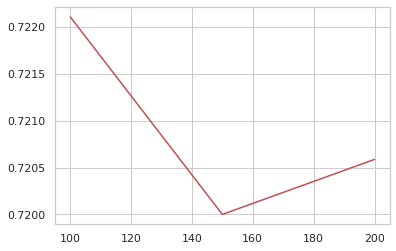

In [25]:
plt.plot(factor_values, mae_values, 'r-')
plt.show()

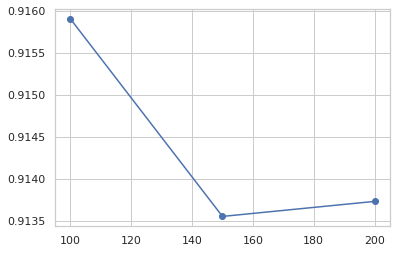

In [26]:
plt.plot(factor_values, rmse_values, 'bo-')
plt.show()

**Paso 8:** Pruebe con otros valores y/o parámetros:

In [27]:
# Ejemplo 2
factor_values = [100, 150, 200, 250, 300, 350, 400] # definir distintos numeros de factores
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE

for f in factor_values:
  svd.train(factors=f, maxiter=100, lr=0.01, lamb=0.1)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

[0.7203382356956806, 0.719776136182383, 0.7206414756650408, 0.7199259316479788, 0.7196363877254465, 0.7203168133910183, 0.7204197579533895]
[0.9144174848166774, 0.913111416271333, 0.9137724197787069, 0.9134476203467984, 0.9128367621452907, 0.9132850307214386, 0.9135028891467797]


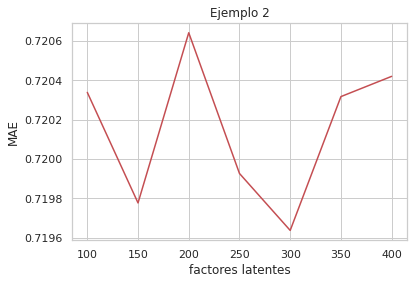

In [29]:
plt.title("Ejemplo 2")
plt.xlabel("factores latentes")
plt.ylabel("MAE")
plt.plot(factor_values, mae_values, 'r-')

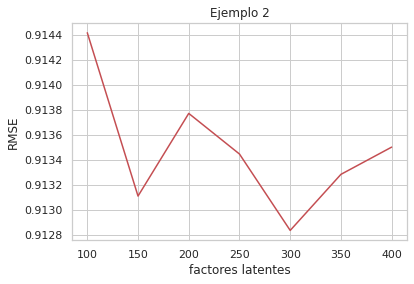

In [30]:
plt.title("Ejemplo 2")
plt.xlabel("factores latentes")
plt.ylabel("RMSE")
plt.plot(factor_values, rmse_values, 'r-')

In [31]:
# Ejemplo 3
maxiter_values = [100, 150, 200, 250, 300, 350, 400] # definir distintos numeros de iteraciones
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE

for max in maxiter_values:
  svd.train(factors=100, maxiter=max, lr=0.01, lamb=0.1)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

[0.7204634840008007, 0.720871631210779, 0.7212798011265948, 0.7216289301221845, 0.7211628348855669, 0.7216562243483249, 0.7214800015597158]
[0.9141975609998464, 0.9146452266381804, 0.9152718273118353, 0.9157085150330783, 0.915209820834496, 0.9157344965843959, 0.9154731094150625]


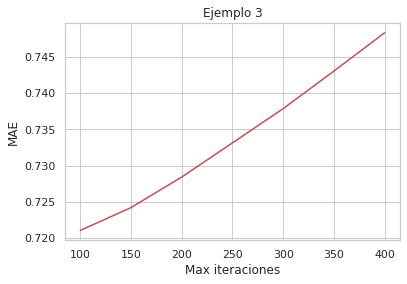

In [35]:
plt.title("Ejemplo 3")
plt.xlabel("Max iteraciones")
plt.ylabel("MAE")
plt.plot(maxiter_values, mae_values, 'r-')

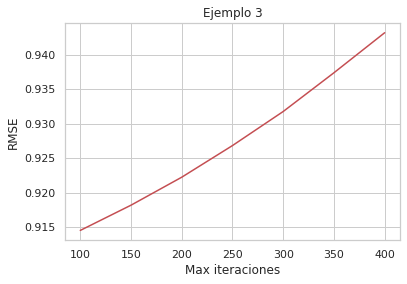

In [36]:
plt.title("Ejemplo 3")
plt.xlabel("Max iteraciones")
plt.ylabel("RMSE")
plt.plot(maxiter_values, rmse_values, 'r-')

In [34]:
# Ejemplo 4
lr_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07] # definir distintos numeros de lr
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE

for lr in lr_values:
  svd.train(factors=100, maxiter=100, lr=lr, lamb=0.1)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

[0.7210545449013874, 0.7242042110828117, 0.7284141606053508, 0.7331272933084472, 0.7378520178889724, 0.7430248847797525, 0.7483121790552341]
[0.9145163371019216, 0.9181746545305792, 0.9222307693872576, 0.9268166050700815, 0.9317551686962997, 0.9373684732204567, 0.9431709026027149]


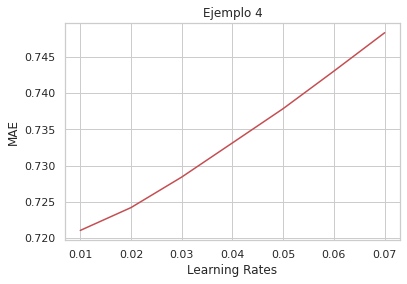

In [37]:
plt.title("Ejemplo 4")
plt.xlabel("Learning Rates")
plt.ylabel("MAE")
plt.plot(lr_values, mae_values, 'r-')

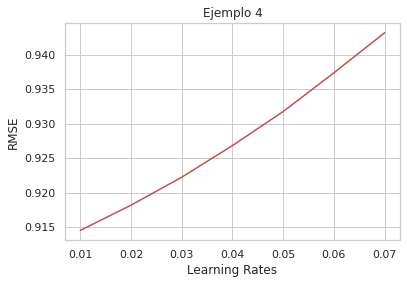

In [38]:
plt.title("Ejemplo 4")
plt.xlabel("Learning Rates")
plt.ylabel("RMSE")
plt.plot(lr_values, rmse_values, 'r-')

In [39]:
# Ejemplo 5
lamb_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7] # definir distintos numeros de lamb
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE

for lamb in lr_values:
  svd.train(factors=100, maxiter=100, lr=0.01, lamb=lamb)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

[0.808466285085676, 0.7758547022458744, 0.7521828770686743, 0.7406635664482333, 0.7341143935177595, 0.7265226747099359, 0.7245428682694931]
[1.030055932492232, 0.9874670512132615, 0.9588178182714645, 0.9448702024310511, 0.9331578452965132, 0.9256201136633118, 0.9214967641075833]


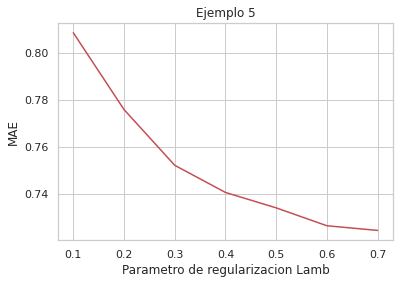

In [40]:
plt.title("Ejemplo 5")
plt.xlabel("Parametro de regularizacion Lamb")
plt.ylabel("MAE")
plt.plot(lamb_values, mae_values, 'r-')

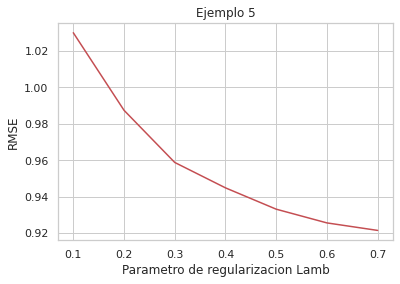

In [41]:
plt.title("Ejemplo 5")
plt.xlabel("Parametro de regularizacion Lamb")
plt.ylabel("RMSE")
plt.plot(lamb_values, rmse_values, 'r-')